# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import scipy
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
-[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

PDF Datasheets
- [Hamamatasu](hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R2083_R3377_TPMH1227E.pdf)

In [2]:
# Constants
c = 0.0299792 # Speed of Light in cm / ps
# Measurements made on a Zoom call with James on March 6th,2022
# xPMT1=8.*cos(-45)*2.54
# yPMT1=8.*sin(-45)*2.54
xPMT1=8.*np.cos(np.radians(-45))*2.54
yPMT1=8.*np.sin(np.radians(-45))*2.54
PMT1_radius = 4.6/2 #cm 
print(f"PMT1 xy=({xPMT1:.2f},{yPMT1:.2f})")
x2PMT1=8.*np.cos(np.radians(-53.72))*2.54 # For test
y2PMT1=8.*np.sin(np.radians(-53.72))*2.54 # For test
print(f"PMT1 xy=({x2PMT1:.2f},{y2PMT1:.2f})")
#
# xPMT4=9.5*cos(110)*2.54
# yPMT4=9.5*sin(110)*2.54
xPMT4=9.5*np.cos(110)*2.54
yPMT4=9.5*np.sin(110)*2.54
print(f"PMT4 xy=({xPMT4:.2f},{yPMT4:.2f})")
# Estimated by Pierre-Simon on March 7th, 2002
# xPMT3=7.*cos(8))*2.54
# yPMT3=7.*sin(80)*2.54
# xPMTG=7.*cos(100)*2.54
# yPMTG=7.*sin(100)*2.54

T3z=0 #cm is the bottom of T3
T1z=33.782 #cm is the bottom of T1
T4z=-28.07297 #cm is the bottom of T4

# The radii of the scintillators are, in cm:
# Rad1=13
# Rad3=3.5
# RadGi=3.5
# RadGo=13.5
# Rad4=18

PMT1 xy=(14.37,-14.37)
PMT1 xy=(12.02,-16.38)
PMT4 xy=(-24.11,-1.07)


In [3]:
scint_radius = 13. # cm
scint_width = 0.5 #
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

### Particle path creator
I chose for the particle to appear first 2cm above the scintillator and then max angle of 40 degrees

```
# PSEUDOCODE
    # Generate random position in circle and random direction in allowed cone
    # Walk
    # while z of particle > lowest z point of T4
    #     if point is outside of scintillator
    #          then step to next scintillator boundary
    #     for each scintillator:
    #          if point is insde of scintillator_i
    #                Generate photons if random number X_1 < Pr(scintillate)
    #                walk mean free path length and store position if still within scintillator
```

In [4]:
def particle_path(t, phi_range_deg, T1_z, T1_width, T4_z, T4_width, T1_radius, mean_free_path, photons_per_E, prob_scint):
    theta = random.uniform(0,2*np.pi)                                                 # random theta in circle above T1
    phi = random.uniform(np.pi-phi_range_deg*np.pi/180/2,np.pi+phi_range_deg*np.pi/180/2) # phi angle pointing in -k given phi range
    maxdist = np.random.random()*T1_radius/2                                          # half the radius of T1
    o = np.float64((maxdist*np.cos(theta), maxdist*np.sin(theta), T1_z+T1_width+2))   # x, y, top of T1_z+2
    u = np.array((np.cos(theta)*np.sin(phi),np.sin(theta)*np.sin(phi),np.cos(phi)),dtype=np.float64)
    print(f"u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
    photons = [0]                          # begin photon array
    points = [o]                           # current point 
    times = [t]                            # current t 
    z = points[-1][2]                      # current z 
    z_1 = (z+mean_free_path*u[2]).round(2) # next z step
    inside_scint = False
    while z_1 >= T4_z:
        if not inside_scint:
            distT1 = np.abs((T1_z+T1_width - z)/u[2])
            distT4 = np.abs((T4_z+T4_width - z)/u[2])
            dist = distT4 if z_1 < T1_z else distT1
#             print(f"t={t:.2f} dist={dist:.2f} distT1={distT1:.2f}, distT4={distT4:.2f} ")
            t +=  dist/c # calculate time in ps passed
            times.append(t)
            points.append(points[-1] + dist*u)
            phot = np.random.poisson(photons_per_E)
            if np.random.random() < prob_scint: photons.append(phot)
            else: photons.append(0)
            z = points[-1][2]
            z_1 = (z+mean_free_path*u[2]).round(2)
        for Tbottom,Ttop in [(T1_z,T1_z+T1_width),(T4_z,T4_z+T4_width)]:
            inside_scint = (z_1 <= (Ttop)) & (z_1 >= Tbottom)
            if inside_scint:
                while inside_scint:
                    t +=  mean_free_path/c
                    times.append(t)
                    points.append(points[-1] + mean_free_path*u)
                    phot = np.random.poisson(photons_per_E)
                    if np.random.random() < prob_scint: photons.append(phot)
                    else: photons.append(0)
                    z = points[-1][2]
                    z_1 = (z+mean_free_path*u[2]).round(2)
                    inside_scint = (z_1 <= (Ttop)) & (z_1 >= Tbottom)
#                     print(f"t={t:.2f} o_z {z:.2f}")
    print(f"time elapsed in scintillators: {np.abs(times[1]-times[-1]):.2f}ps total scintillation points: {len(points[1:])}")
    return np.array(times, dtype=np.float64)[1:], np.array(points, dtype=np.float64)[1:], np.array(photons[1:], dtype=np.float64)

In [5]:
times, points, photons = particle_path(t=2, phi_range_deg=40, T1_z=T1z, T1_width=0.5, 
                                       T4_z=T4z, T4_width=1, T1_radius=13, mean_free_path=0.05, 
                                       photons_per_E=10, prob_scint=0.8)

u=(0.07,-0.16,-0.98)
time elapsed in scintillators: 2112.10ps total scintillation points: 32


<IPython.core.display.Javascript object>


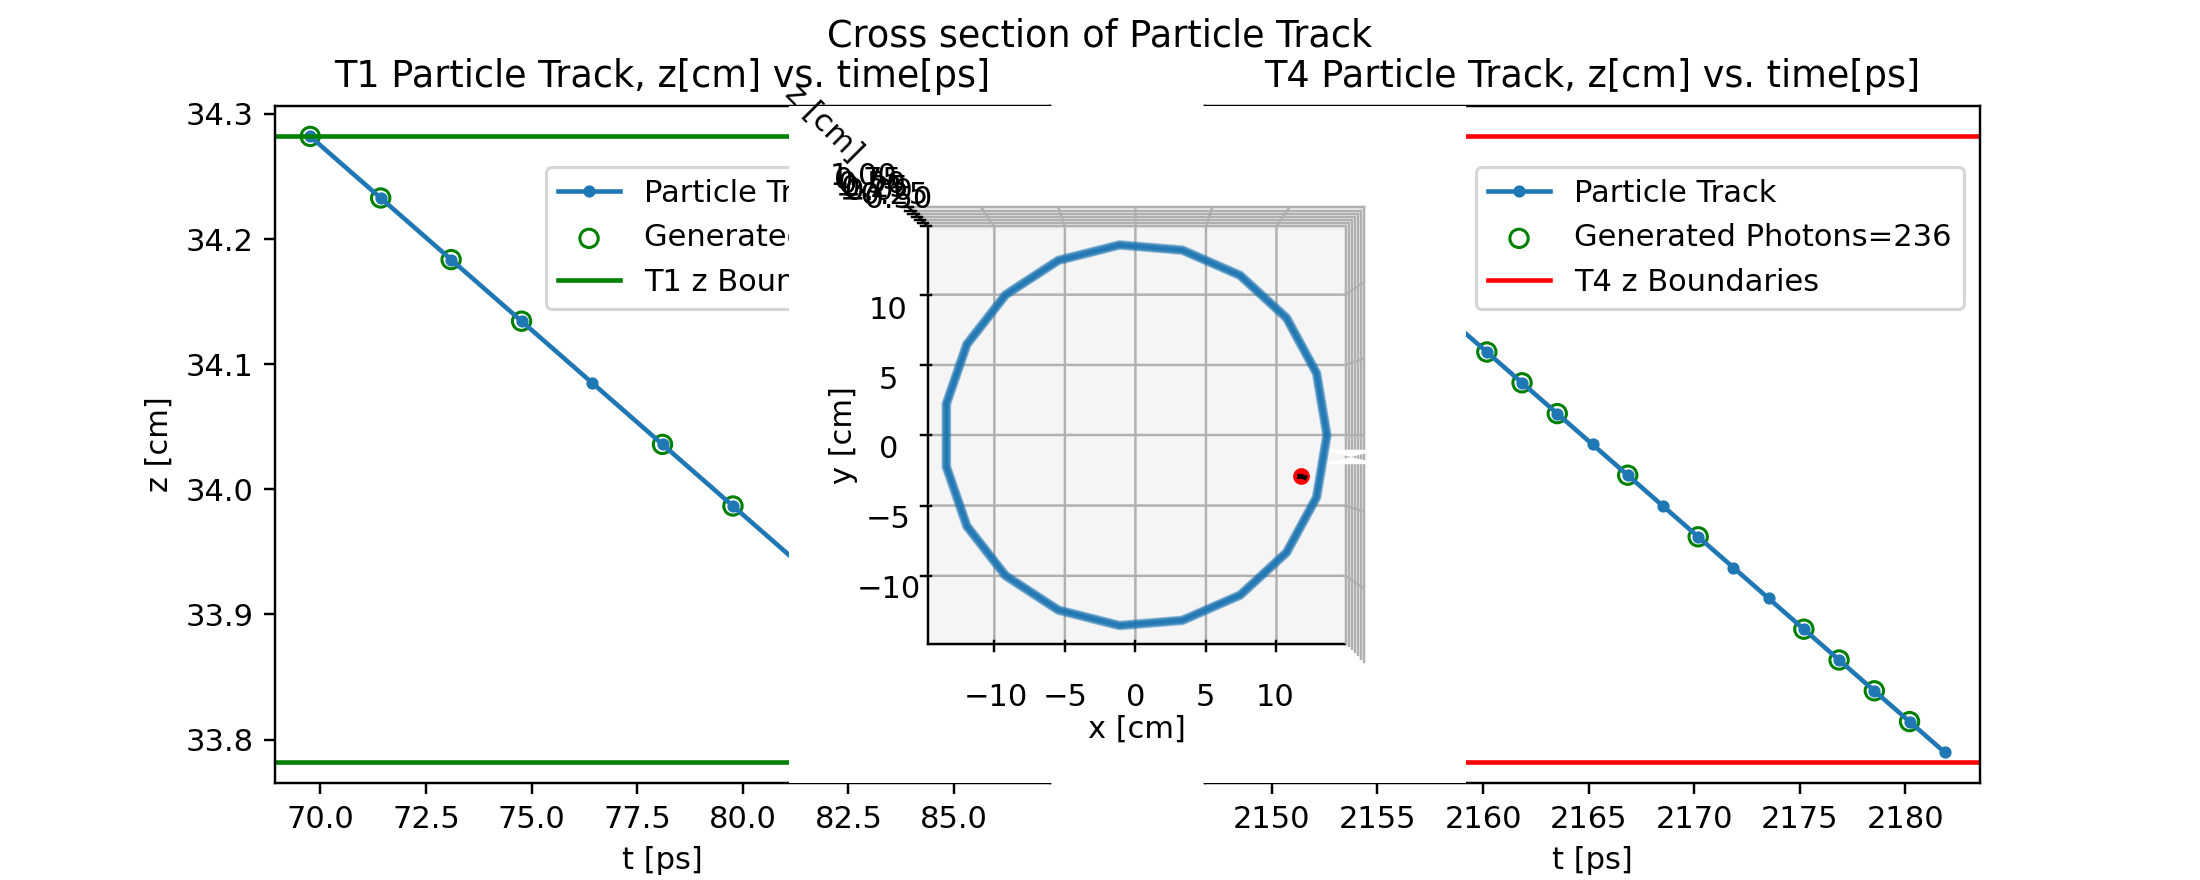

In [6]:
fig0, ax0 = plt.subplots(1,2,figsize=(10,4))
t1mask = points[:,2]>= T1z-1
t4mask = points[:,2]<= T1z-1
photont1mask = (photons != 0) & t1mask
photont4mask = (photons != 0) & t4mask
ax0[0].plot(times[t1mask],(points[t1mask])[:,2],marker='.', label='Particle Track')
ax0[1].plot(times[t4mask],(points[t4mask])[:,2],marker='.', label='Particle Track')
ax0[0].scatter(times[photont1mask],(points[photont1mask])[:,2], color='green', marker='o', facecolors='none', label=f'Generated Photons={np.sum(photons):.0f}')
ax0[1].scatter(times[photont4mask],(points[photont4mask])[:,2], color='green', marker='o', facecolors='none', label=f'Generated Photons={np.sum(photons):.0f}')

ax0[1].axhline(T4z,color='red', label='T4 z Boundaries')
ax0[1].axhline(T4z+1,color='red')
ax0[0].axhline(T1z,color='green', label='T1 z Boundaries')
ax0[0].axhline(T1z+0.5,color='green')
ax0[0].set_xlabel('t [ps]');ax0[1].set_xlabel('t [ps]')
ax0[0].set_ylabel('z [cm]');ax0[1].set_ylabel('z [cm]')
fig0.suptitle('Cross section of Particle Track')
ax0[0].set_title('T1 Particle Track, z[cm] vs. time[ps]')
ax0[1].set_title('T4 Particle Track, z[cm] vs. time[ps]')
ax0[0].legend(loc=[0.35, 0.70])
ax0[1].legend(loc=[0.35, 0.70])
plt.show()

### Photon path tracker

**Geometries**

In [7]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z,pos_z):
    z = np.linspace(pos_z, pos_z+height_z, 20)
    theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
def sphere():   
    phi = np.linspace(1,10,100)
    Phi, Theta = np.meshgrid(phi, phi)
    x = np.cos(Phi)*np.sin(Theta)
    y = np.sin(Phi)*np.sin(Theta)
    z = np.cos(Theta)
    return x,y,z

### Light Guide Building

How about if we build the tube as a square with a condition past a plane to continute to reflect to the PMT

In [8]:
def light_guide(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    theta_grid, z_grid = np.meshgrid(theta[theta >= (3*np.pi/2)], z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
def light_guide_cuboid(center, size, border_radius):
    """
   Create a data array for cuboid plotting.
   ============= ================================================
   Argument      Description
   ============= ================================================
   center        center of the cuboid, triple
   size          size of the cuboid, triple, (x_length,y_width,z_height)
   :type size: tuple, numpy.array, list
   :param size: size of the cuboid, triple, (x_length,y_width,z_height)
   :type center: tuple, numpy.array, list
   :param center: center of the cuboid, triple, (x,y,z)
    """
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z
def light_guide_corner(border_point, height_z, border_radius): 
    z = np.linspace(0, height_z, 20)
    theta = np.linspace(0, -np.pi/2, 20)
    theta_grid, z = np.meshgrid(theta, z)
    x = border_radius*np.cos(theta_grid) + border_point[0]-border_radius
    y = border_radius*np.sin(theta_grid) + border_point[1]+border_radius
    return x,y,z

<IPython.core.display.Javascript object>


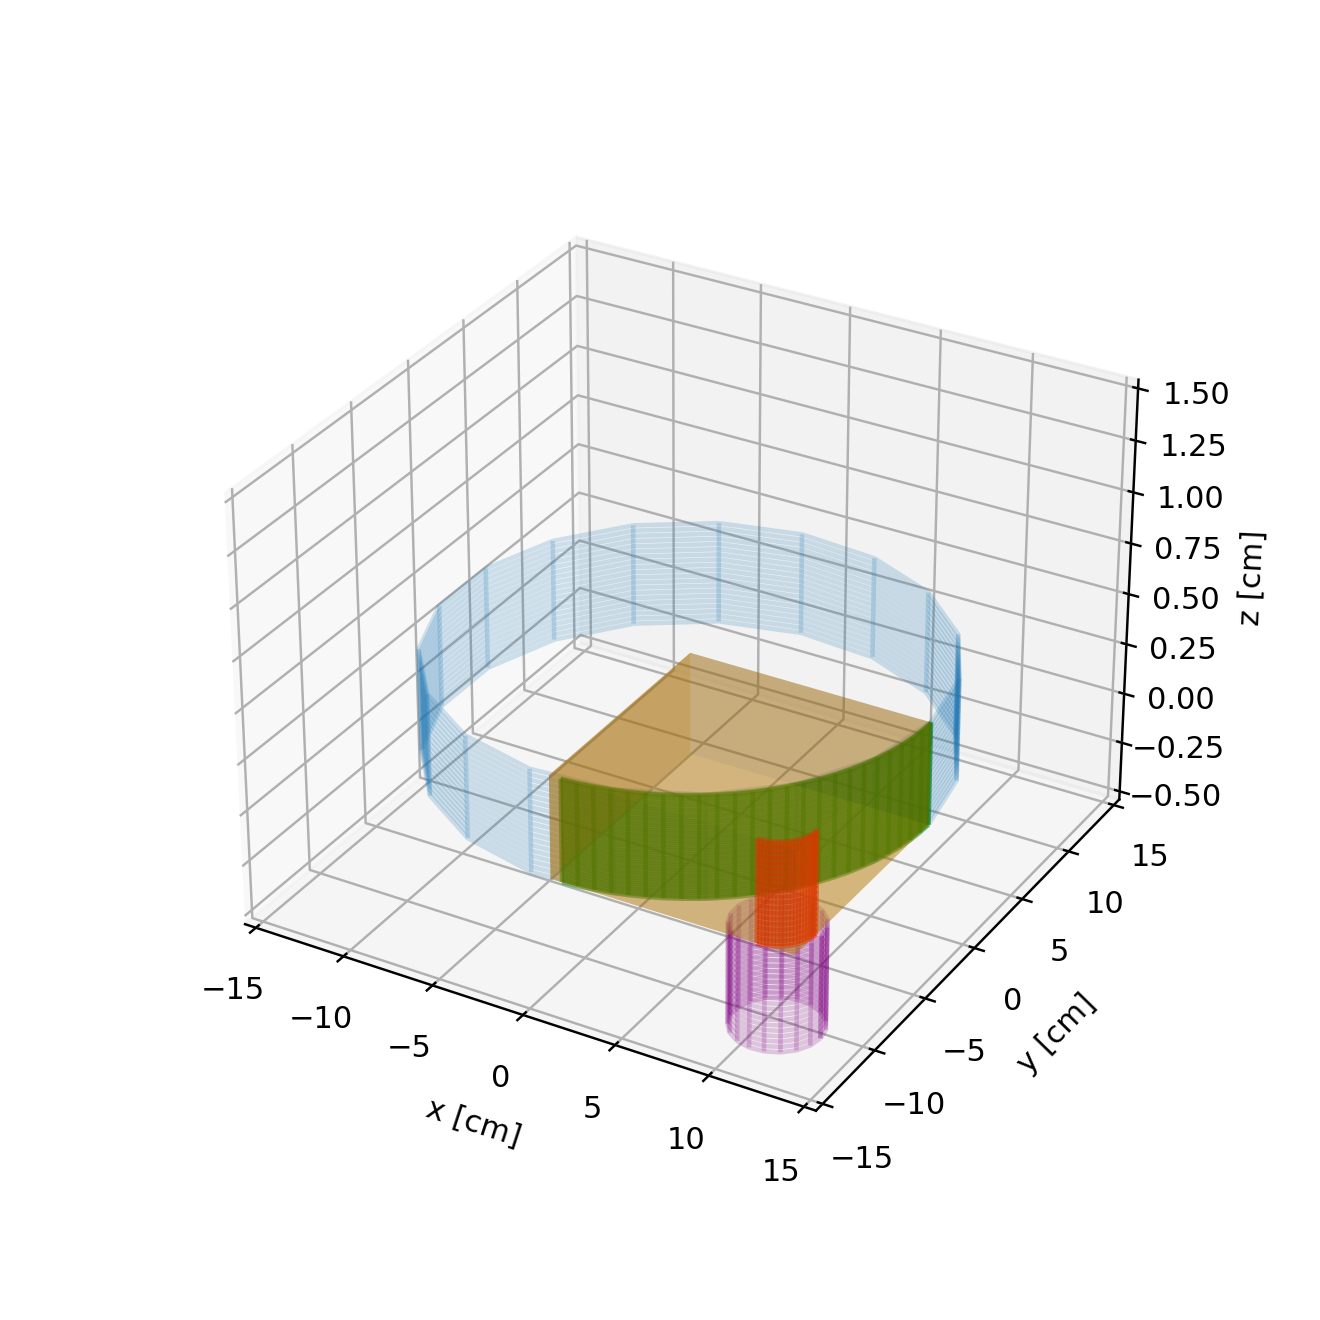

In [9]:
# Light tube building
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, projection='3d')
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5,pos_z=0)
LX, LY, LZ = light_guide(0,0,scint_radius,0.5)
xyz = (scint_radius/2,-scint_radius/2,scint_width/2)
hwd = np.array([scint_radius, scint_radius, scint_width])
SX, SY, SZ = light_guide_cuboid(xyz, hwd, 1)
xyz = np.array([scint_radius, -scint_radius])
SphX, SphY, SphZ = light_guide_corner(xyz, height_z=scint_width, border_radius=scint_width*4)
PMT_X, PMT_Y, PMT_Z = data_for_cylinder_along_z(scint_radius-4*scint_width,-scint_radius+4*scint_width,PMT1_radius,0.5,pos_z=-.5)
ax1.plot_wireframe(X, Y, Z, alpha=0.2)
ax1.plot_wireframe(LX, LY, LZ, alpha=0.5, color='green')
ax1.plot_surface(SX, SY, SZ, alpha=0.2, color='orange')
ax1.plot_wireframe(SphX, SphY, SphZ, alpha=0.5, color='red')
ax1.plot_wireframe(PMT_X, PMT_Y, PMT_Z, alpha=0.2, color='purple')
# ax1.scatter(x2PMT1,y2PMT1,0)
# ax1.scatter(xPMT4,yPMT4,0)
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
ax1.set_zlabel('z [cm]')
ax1.set_xlim([-15,15])
ax1.set_ylim([-15,15])
ax1.set_zlim([-0.5,1.5])
plt.show()

$$ R_s = \Bigg\vert\frac{n_1\cos\theta_i - n_2\cos\theta_t}{n_1\cos\theta_i+n_2\cos\theta_t}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\cos\theta_i - n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}{n_1\cos\theta_i + n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}\Bigg\vert^2
$$
$$ R_p = \Bigg\vert\frac{n_1\cos\theta_t - n_2\cos\theta_i}{n_1\cos\theta_t+n_2\cos\theta_i}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} - n_2\cos\theta_i}{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} + n_2\cos\theta_i}\Bigg\vert^2
$$

$$ \sin\theta = \frac{\lVert \vec u \times \vec n \lVert}{\lVert \vec u \lVert \lVert \vec n \lVert}$$

In [10]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def mag(x):
    return np.linalg.norm(x)

In [63]:
def distance_solver(u, o, center, radius, plane_z, border_radius):
    dcircle = distance_circle(u,o,center,radius)
    dplane_z = distance_plane(u,o,plane_z)
    if (o[0] > 0) & (o[1] < 0) & ((o[0]**2+o[1]**2) >= radius**2-1):
        print("LIGHT GUIDE CONDITION!")
        return distance_light_guide(u, o, center, radius, plane_z, border_radius)
    else:
        return dplane_z if dcircle > dplane_z else dcircle
def distance_light_guide(u, o, center, radius, plane_z, border_radius):
    dplanex = distance_plane(u,o,radius,dim=0) # checks x
    dplaney = distance_plane(u,o,radius,dim=1) # checks y
    dplanez = distance_plane(u,o,plane_z,dim=2) # check z
    dcorner = distance_circle(u,o, (center[0]+radius-border_radius,center[1]+radius+border_radius,center[2]), radius, True)
    return np.min([dplanex,dplaney,dplanez,dcorner])
        
def distance_circle(u, o, center, radius, quadrant=False): #3d directional vector, 3d point, center of scintillator, radius of scintillator
    P = o
    D = u*-1 if np.dot(u,P) < 0 else u
    C = center
    R = radius
    bigDelta = P-C
    # t = -D . ∆ ± √(D . ∆)^2 - |D|^2(|∆|^2 - R^2)
    #     over |D|^2
    magDsq = mag(D)**2
    magDeltasq = mag(bigDelta)**2
    DdotDelta = np.dot(D,bigDelta)
    if DdotDelta**2 - magDsq * (magDeltasq - R**2) < 0:
        return 100
    sqrt_term = np.sqrt(DdotDelta**2 - magDsq * (magDeltasq - R**2))/magDsq
    b_term = -DdotDelta/magDsq
    rootA = b_term - sqrt_term
    rootB = b_term + sqrt_term
    if quadrant is not False:
        print("using quadrand circle distance")
        return np.abs(rootA) if np.abs(rootA) > np.abs(rootB) else np.abs(rootB)
    return np.abs(rootA) if (rootA < 0) & (np.dot(u,P) < 0) else np.abs(rootB)
#     return -rootA if (rootA < 0) & (np.dot(u,P) < 0) else (-rootB if np.dot(u,P) < 0 else rootB)
def distance_plane(u, o, plane, dim=2): #3d directional vector, 3d point, z positions of planes bottom and top
    P = o
    if dim==2:
        d_plane = plane[0] if u[dim] < 0 else plane[1] # make sure direction matches location of plane 
    else:
        d_plane = plane
    return np.abs((d_plane - P[dim])/u[dim])

```
# PSEUDOCODE
    # if random number X_1 < mean ( Reflectance s_polarization + Reflectance s_polarization ):
        # Reflect
    # else if random number X_2 < absorbption into scintillator boundary probability:
        # Absorbed and exit current particle simulation
    # else if not absorbed:
        # assume photon transmitted through boundary, 
        # absorbed by white paint and reemmitted back 
        # into scintillator with random direction given by random angles Phi_3, Theta_3
        # with constraint of z coordinate entering
```

#### TO-DO LIST
- Fix retransmit so that it actually transmits into housing and executes white paint interation
- Light tube design + geometry, plus accuract $\vec{n}$ vector calculation
    - Find way to calculate n vector with equation for scint light guide
- find a mean free path and then at each mean calculate the random.poisson(mean) which is the time to the next scintillation

In [76]:
def n_vec_calculate(o, scint_plane, light_guide_planes, corner_center, corner_radius):
    if o[2] == scint_plane[0]: # bottom of scint
        return np.array([0,0,+1])
    elif o[2] == scint_plane[1]: # top of scint
        return np.array([0,0,-1])
    elif o[0] == light_guide_planes[0]:
        return np.array([0,+1,0])
    elif o[1] == light_guide_planes[1]:
        return np.array([-1,0,0])
    elif (o[0] > corner_center[0]) & (o[1] < corner_center[1]): # in corner
        return normalize(o-corner_center)
    else: # in main scintillator
        return normalize(o-np.zeros(3))
def photon_interaction(o, u, n, notabsorbed, scint_plane):
    u_i = u
    u_r = u - 2*np.dot(u, n)*n # u_new = u - 2 (u . n)*n
    # CONDITION n_1 <= n_2
    n_1 = 1.000293 # 1.85 for NaI
    n_2 = 1.5 # Sample index of refraction of air
    v = u*-1 if np.dot(u,n) < 0 else u
    theta = np.arcsin(mag(np.cross(v,n))/(mag(u)*mag(n)))
#     theta = np.arccos(mag(np.dot(v,n))/(mag(u)*mag(n)))
    inside_sqrt = ((n_1/n_2)*np.sin(theta))**2
    sqrt_term = np.sqrt(1 - inside_sqrt)
    Rs = np.abs((n_1*np.cos(theta) - n_2*sqrt_term)/(n_1*np.cos(theta) + n_2*sqrt_term))**2
    Rp = np.abs((n_1*sqrt_term - n_2*np.cos(theta))/(n_1*sqrt_term + n_2*np.cos(theta)))**2
    # Determine probability of reflectance
    if np.random.random() < ((Rs+Rp)/2): # reflect !
        print("reflect!")
        notabsorbed = True
        return u_r, notabsorbed
    # then photon is transmitted to white paint
    elif np.random.random() < 0.20: # does it get absorbed? change probability when you get more data
        print("absorbed!")
        notabsorbed = False
        return u_r, notabsorbed
    else: # no it didn't get absorbed!
        print("retransmit in new direction!")
        notabsorbed = True
        theta_new = random.uniform(0,2*np.pi)           # new theta direction of photon
        phi_new = random.uniform(0,np.pi)# if o[2] == scint_plane[0] else random.uniform(np.pi/2,np.pi)              # new phi   direction of photon
        u_r = u_r + (np.random.random()-0.5)*normalize(np.array([np.sin(phi_new)*np.cos(theta_new),np.sin(phi_new)*np.sin(theta_new),np.cos(phi_new)]))
        print(f"z={o[2]:.2f} phi_new > π/2={phi_new>np.pi/2} u_new={u_r[2]:.2f}")
#         u_r = u - 2*np.dot(u, n)*n
        return u_r, notabsorbed

def scintillator_monte_carlo(o, x_pmt, notabsorbed, scint_radius, scint_plane, scint_width, light_guide_planes, N_max, dt):
    print(f"Starting position (x_0,y_0,z_0) = ({o[0]:.2f},{o[1]:.2f},{o[2]:.2f})")
    track_history = np.zeros((N_max+1,7))         # x, y history of Photon
    corner_radius = scint_width*4
#     theta = random.uniform(0,2*np.pi)             # first theta direction of photon
#     phi = random.uniform(0,np.pi)                 # first phi   direction of photon
    theta = 7*np.pi/4
    phi = np.pi/2
    u = np.array([np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]) # first direction unit vector
    track_history[0,:] = [o[0],o[1],o[2],u[0],u[1],u[2],notabsorbed]
    i = 1
    while (i < N_max+1) & (o[0] < x_pmt) & (notabsorbed is True):
        ds = distance_solver(u, o, np.zeros(3),scint_radius, scint_plane, corner_radius)
        x, y, z = o+ds*u
        dt = np.abs(ds)/c if np.abs(ds)>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: ds={ds:.2f}cm dt={dt:.2f}ps Absorbed?={not notabsorbed} xyz =({x:.2f},{y:.2f},{z:.2f}) u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
        print(f"LIGHT GUIDE CONDITION={(o[0]**2+o[1]**2):.2f} vs. radius^2={scint_radius**2-1:.2f}")
        o = np.array([x, y, np.abs(z) if np.abs(z-scint_plane).any() < 1e-5 else z])
        n = n_vec_calculate(o, scint_plane, light_guide_planes, [scint_radius-corner_radius,-scint_radius+corner_radius], corner_radius)
        u, notabsorbed = photon_interaction(o, u, n, notabsorbed, scint_plane)
#         u[2] = np.abs(u[2]) if z == scint_plane[0] else -np.abs(u[2])
        track_history[i] = [x,y,z,u[0],u[1],u[2],notabsorbed]
        i+=1
    if i < N_max+1:
        track_history = track_history[:i,:]
        
    print(f"DONE Absorbed?={not notabsorbed}")
    return track_history

<IPython.core.display.Javascript object>


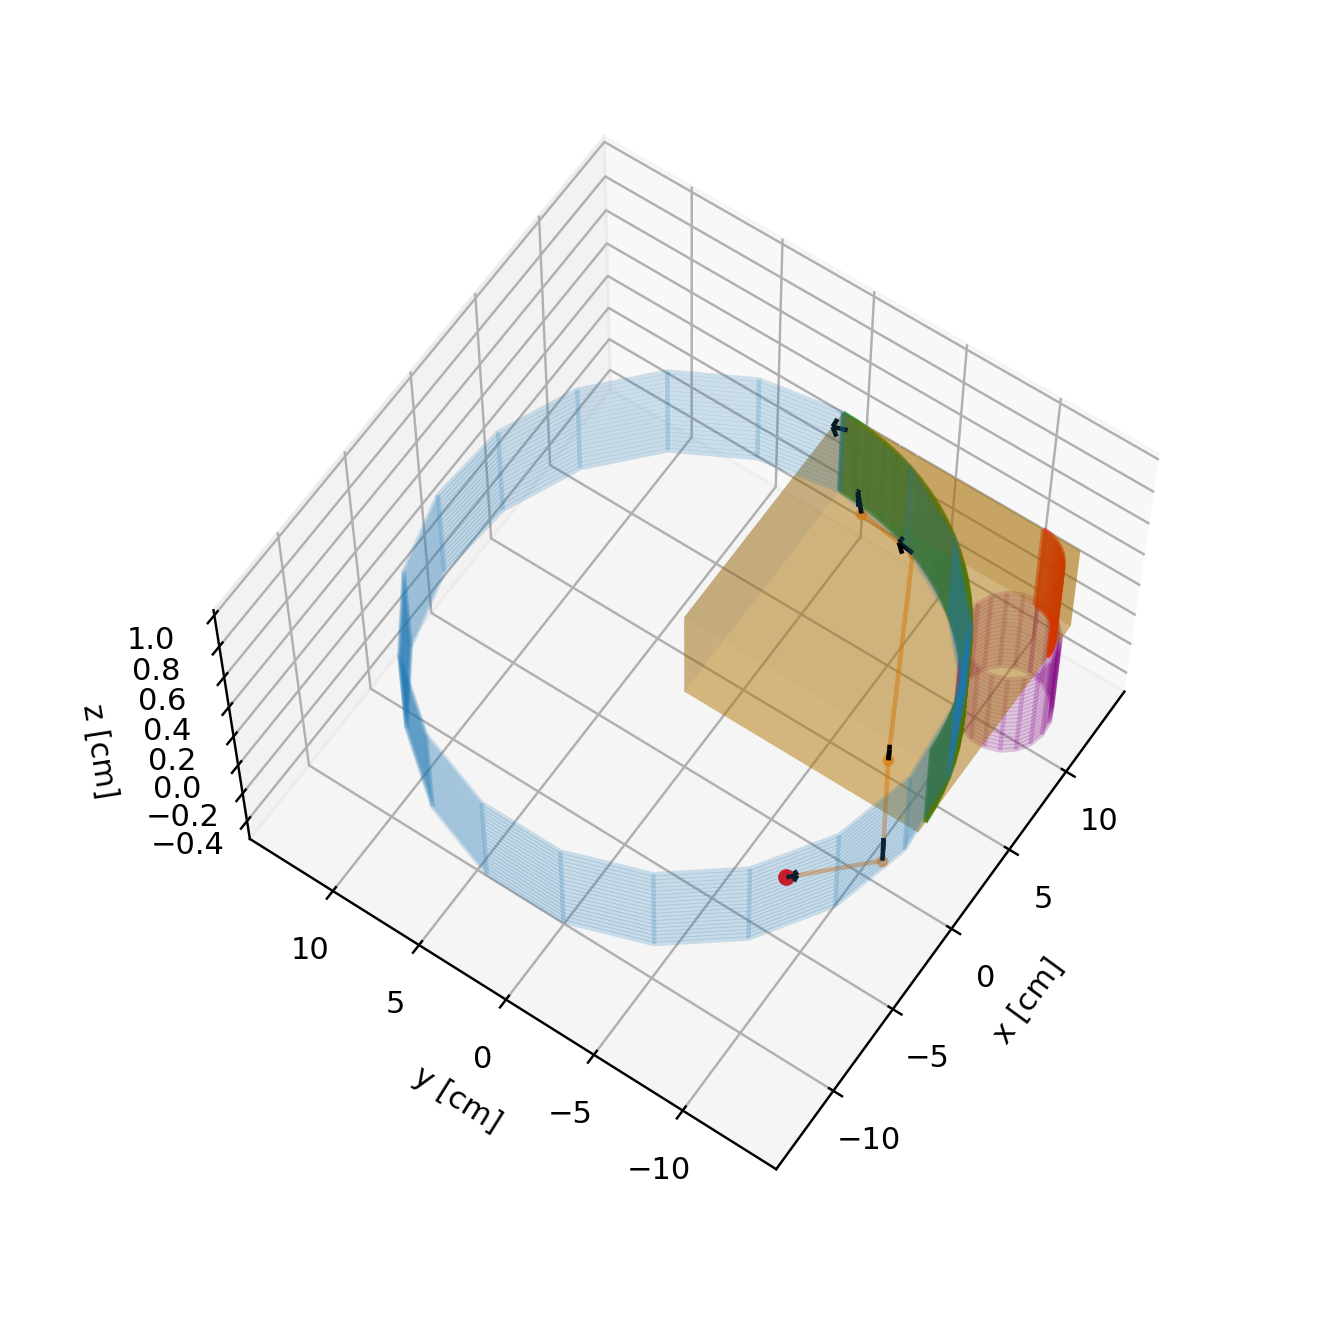

Starting position (x_0,y_0,z_0) = (-5.78,-9.58,0.08)
step 1: ds=4.45cm dt=148.38ps Absorbed?=False xyz =(-2.63,-12.73,0.08) u=(0.71,-0.71,0.00)
LIGHT GUIDE CONDITION=125.26 vs. radius^2=168.00
retransmit in new direction!
z=0.08 phi_new > π/2=False u_new=0.19
step 2: ds=2.22cm dt=73.99ps Absorbed?=False xyz =(-0.86,-11.65,0.50) u=(0.80,0.49,0.19)
LIGHT GUIDE CONDITION=168.99 vs. radius^2=168.00
retransmit in new direction!
z=0.50 phi_new > π/2=True u_new=-0.05
step 3: ds=10.77cm dt=359.14ps Absorbed?=False xyz =(12.10,-4.75,0.00) u=(1.20,0.64,-0.05)
LIGHT GUIDE CONDITION=136.43 vs. radius^2=168.00
retransmit in new direction!
z=0.00 phi_new > π/2=False u_new=0.10
LIGHT GUIDE CONDITION!
using quadrand circle distance
step 4: ds=1.83cm dt=60.94ps Absorbed?=False xyz =(11.20,-2.36,0.19) u=(-0.49,1.31,0.10)
LIGHT GUIDE CONDITION=169.00 vs. radius^2=168.00
retransmit in new direction!
z=0.19 phi_new > π/2=True u_new=0.11
step 5: ds=1.92cm dt=64.09ps Absorbed?=False xyz =(12.99,-0.30,0.41) u

In [77]:
# Plot
fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(111, projection='3d')
# ax2.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint), 0)
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5, 0)
ax2.plot_wireframe(X, Y, Z, alpha=0.2)
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r), np.random.random()*scint_width) # x, y
ax2.scatter(random_track[0],random_track[1],random_track[2], color='red', marker='o')
# pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
y_plus_l = y+length_pmt_window
x_plus_w = x+width_pmt_window
x_pmt = [x,x_plus_w,x,x_plus_w]
y_pmt = [y,y,y_plus_l,y_plus_l]
z_pmt = [0,0,0,0]
verts = [list(zip(x_pmt,y_pmt,z_pmt))]

ax2.add_collection3d(Poly3DCollection(verts, facecolors='w'))
# plt.show()
# ax2.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track, x_pmt=scint_radius, 
                                  notabsorbed=True, scint_radius=scint_radius, 
                                  scint_plane=np.array([0.0,0.5]), scint_width=0.5, 
                                  light_guide_planes=[scint_radius,-scint_radius], 
                                  N_max=8, dt=0.2)
ax2.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], length=np.array([0,0.5]).max(), edgecolor='k', facecolor='black', linewidth=1.5)#, pivot='tail')#, normalize=True)

# ax2.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], scale=10)
line = ax2.plot(tracks[:,0],tracks[:,1],tracks[:,2], alpha=0.5, color='C1', marker='.')
ax2.plot_wireframe(LX, LY, LZ, alpha=0.5, color='green')
ax2.plot_surface(SX, SY, SZ, alpha=0.2, color='orange')
ax2.plot_wireframe(SphX, SphY, SphZ, alpha=0.5, color='red')
ax2.plot_wireframe(PMT_X, PMT_Y, PMT_Z, alpha=0.2, color='purple')
ax2.grid(True)
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')
ax2.set_zlabel('z [cm]')
ax2.set_zlim([-0.5,1])
ax2.view_init(elev=90, azim=-90, roll=0)
plt.show()

### PMT signal making

```
PSEUDOCODE
    execute Nmax times:
        start counting photoelectrons
        for each incident photon:
            if random number X_2 < Quantum Efficiency then add a photoelectron
        set electrons equal to photoelectrons
        for each dynode:
            -set dynode amplification to change in ∆Voltage/(20 Volts per electron)
            -increase electrons by poisson distributed random number with mean
            around amplification * current electrons
        if electrons generated > 1:
            add to pmtSignal count
```

In [ ]:
# Reference to c resource
def photoElectrons(photons, QE): # Main monte carlo
    pe = 0. 
    for i in range(int(photons)):
        if np.random.random()<QE:
            pe+=1
    return pe
def photontoElectrons(photons, V, QE, N, E_per_electron):
    e = photoElectrons(photons, QE)
    for dynode in range(N-1):
        delta_voltage = V[dynode+1]-V[dynode]
        e += np.random.poisson(e*delta_voltage/E_per_electron)
    return e
def genSignal(incident_photons, V, QE, n_dynodes, E_per_electron, Nmax):
    pmtSignal = []
    for i in range(Nmax): # Monte carlo # of iterations
        if ((i) % (Nmax//4)) == 0: print(f"step {i}/{Nmax}")
        e = photontoElectrons(incident_photons, V, QE, n_dynodes, E_per_electron)
        if e>1:
            pmtSignal.append(e)
    print(f"pmtSignal mean {np.mean(pmtSignal):.0f}")
    return pmtSignal

In [ ]:
n_dynodes = 8
V = np.linspace(150,850,n_dynodes)
# V = [150,300,350,600,750,850]
n_incident_photons = 10000
E_per_electron = 20
Nmax = 100000
QE = 0.23
pmtSignal = genSignal(1, V, QE, n_dynodes, E_per_electron, Nmax)

In [ ]:
print("Dynode Voltages =", V)
fig4, ax4 = plt.subplots(figsize=(6,6))
extent, bin_edges, params = ax4.hist(pmtSignal, bins=50, label='Frequency of Secondary Electrons')
centers = (1/2) * (bin_edges[:-1] + bin_edges[1:])
# centers = np.arange(int(min(centers)),int(max(centers)),int(max(centers))/51)
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

out = scipy.optimize.leastsq(errfunc, [200,np.mean(pmtSignal),1e6,100], args=(centers, extent))
parameters4 = out[0]
print(f"Gaussian Fitted (x) = {parameters4[0]:.2e} exp[-1/2 * (x - {parameters4[1]:.2e}) / {parameters4[2]:.2e}] + {parameters4[3]:.2e}")
print(f"mu = {parameters4[1]:.2e}, sigma^2 = {parameters4[2]:.2e}")
ax4.plot(centers, fitfunc(parameters4,centers),label="Gaussian Fitted Function")
ax4.set_title('Simulated PMT Signal fitted to Gaussian')
ax4.set_ylabel('Count')
ax4.set_xlabel('# of Anode Electrons')
ax4.legend()
# ax4.set_xscale('log')
# ax4.set_yscale('log')
ax4.grid(True)
plt.show()